# Used Cars Predictions
### Data 622 Spring 2024
### Euclides Rodriguez

## Libraries

In [68]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

warnings.filterwarnings('ignore')

## Importing Data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/engine2031/Data-Sets/main/car%20details%20v4.csv", encoding='unicode_escape')

In [3]:
df.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                2059 non-null   object 
 1   Model               2059 non-null   object 
 2   Price               2059 non-null   int64  
 3   Year                2059 non-null   int64  
 4   Kilometer           2059 non-null   int64  
 5   Fuel Type           2059 non-null   object 
 6   Transmission        2059 non-null   object 
 7   Location            2059 non-null   object 
 8   Color               2059 non-null   object 
 9   Owner               2059 non-null   object 
 10  Seller Type         2059 non-null   object 
 11  Engine              1979 non-null   object 
 12  Max Power           1979 non-null   object 
 13  Max Torque          1979 non-null   object 
 14  Drivetrain          1923 non-null   object 
 15  Length              1995 non-null   float64
 16  Width 

In [5]:
#Data prepration. String clean up.  Converting object columns to numerial.  
df[['Max Power_hp', 'Max Power_rpm']] = df['Max Power'].str.split('@', n=1, expand=True)
df[['Max Torque_nm', 'Max Torque_rpm']] = df['Max Torque'].str.split('@', n=1, expand=True)

df['Max Power_hp'] = df['Max Power_hp'].str.replace('bhp', '')
df['Max Power_rpm'] = df['Max Power_rpm'].str.replace('rpm', '')

df['Max Torque_nm'] = df['Max Torque_nm'].str.replace('Nm', '')
df['Max Torque_rpm'] = df['Max Torque_rpm'].str.replace('rpm', '')

df['Engine'] = df['Engine'].str.replace('cc', '')

#convert_num = ['Engine','Max Torque_rpm', 'Max Torque_nm','Max Power_hp', 'Max Power_rpm']

#for i in convert_num:  
    #df[i] = pd.to_numeric(df[i])

In [6]:
df = df.drop(['Max Power', 'Max Torque'], axis=1)

In [7]:


convert_num = ['Engine','Max Torque_rpm', 'Max Torque_nm','Max Power_hp', 'Max Power_rpm']

#df_temp_num = df_temp.apply(pd.to_numeric, errors ='coerce')

for i in convert_num:
    df[i] = df[i].apply(pd.to_numeric, errors='coerce')  
 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                2059 non-null   object 
 1   Model               2059 non-null   object 
 2   Price               2059 non-null   int64  
 3   Year                2059 non-null   int64  
 4   Kilometer           2059 non-null   int64  
 5   Fuel Type           2059 non-null   object 
 6   Transmission        2059 non-null   object 
 7   Location            2059 non-null   object 
 8   Color               2059 non-null   object 
 9   Owner               2059 non-null   object 
 10  Seller Type         2059 non-null   object 
 11  Engine              1979 non-null   float64
 12  Drivetrain          1923 non-null   object 
 13  Length              1995 non-null   float64
 14  Width               1995 non-null   float64
 15  Height              1995 non-null   float64
 16  Seatin

In [9]:
#Summary for Numerical Values
df.select_dtypes(['float64', 'int64']).describe().transpose()[['count', 'mean', 'min', 'max','50%']]

,count,mean,min,max,50%
Price,2059.0,1.702992e+06,49000.0,35000000.0,825000.0
Year,2059.0,2.016425e+03,1988.0,2022.0,2017.0
Kilometer,2059.0,5.422471e+04,0.0,2000000.0,50000.0
Engine,1979.0,1.692576e+03,624.0,6592.0,1498.0
Length,1995.0,4.280861e+03,3099.0,5569.0,4370.0
Width,1995.0,1.767992e+03,1475.0,2220.0,1770.0
Height,1995.0,1.591735e+03,1165.0,1995.0,1545.0
Seating Capacity,1995.0,5.306266e+00,2.0,8.0,5.0
Fuel Tank Capacity,1946.0,5.200221e+01,15.0,105.0,50.0
Max Power_hp,1979.0,1.296118e+02,35.0,660.0,116.0


In [10]:
df.select_dtypes(['object']).columns

Index(['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color',
       'Owner', 'Seller Type', 'Drivetrain'],
      dtype='object')

In [11]:
#Unique Values for Categorical Features
object_list = df.select_dtypes(['object']).columns

for i in object_list:
    print(f"{i} = {df[i].nunique()}")

Make = 33
Model = 1050
Fuel Type = 9
Transmission = 2
Location = 77
Color = 17
Owner = 6
Seller Type = 3
Drivetrain = 3


In [12]:
#Removing select categorical variables to avoid curse of dimensionality
df = df.drop(['Model', 'Location'], axis=1)


In [13]:
df.select_dtypes(['object']).columns

Index(['Make', 'Fuel Type', 'Transmission', 'Color', 'Owner', 'Seller Type',
       'Drivetrain'],
      dtype='object')

In [14]:
object_list2 = df.select_dtypes(['object']).columns

In [15]:
df.dtypes

Make                   object
Price                   int64
Year                    int64
Kilometer               int64
Fuel Type              object
Transmission           object
Color                  object
Owner                  object
Seller Type            object
Engine                float64
Drivetrain             object
Length                float64
Width                 float64
Height                float64
Seating Capacity      float64
Fuel Tank Capacity    float64
Max Power_hp          float64
Max Power_rpm         float64
Max Torque_nm         float64
Max Torque_rpm        float64
dtype: object

## Dealing With Missing Data 

In [16]:
df.isnull().sum()

Make                    0
Price                   0
Year                    0
Kilometer               0
Fuel Type               0
Transmission            0
Color                   0
Owner                   0
Seller Type             0
Engine                 80
Drivetrain            136
Length                 64
Width                  64
Height                 64
Seating Capacity       64
Fuel Tank Capacity    113
Max Power_hp           80
Max Power_rpm          84
Max Torque_nm          80
Max Torque_rpm         80
dtype: int64

In [17]:
#Drop rows with missing data
df.dropna(inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1872 entries, 0 to 2057
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                1872 non-null   object 
 1   Price               1872 non-null   int64  
 2   Year                1872 non-null   int64  
 3   Kilometer           1872 non-null   int64  
 4   Fuel Type           1872 non-null   object 
 5   Transmission        1872 non-null   object 
 6   Color               1872 non-null   object 
 7   Owner               1872 non-null   object 
 8   Seller Type         1872 non-null   object 
 9   Engine              1872 non-null   float64
 10  Drivetrain          1872 non-null   object 
 11  Length              1872 non-null   float64
 12  Width               1872 non-null   float64
 13  Height              1872 non-null   float64
 14  Seating Capacity    1872 non-null   float64
 15  Fuel Tank Capacity  1872 non-null   float64
 16  Max Power_h

## Splitting the Data 

In [19]:
X = df.drop(columns=["Price"])
y = df["Price"]

## One-Hot Encoding 

In [20]:
# One hot encode variables 

X_encoded = pd.get_dummies(X, columns=object_list2)

X_encoded.head()

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,Max Power_hp,Max Power_rpm,...,Owner_First,Owner_Second,Owner_Third,Owner_UnRegistered Car,Seller Type_Commercial Registration,Seller Type_Corporate,Seller Type_Individual,Drivetrain_AWD,Drivetrain_FWD,Drivetrain_RWD
0,2017,87150,1198.0,3990.0,1680.0,1505.0,5.0,35.0,87.0,6000.0,...,True,False,False,False,False,True,False,False,True,False
1,2014,75000,1248.0,3995.0,1695.0,1555.0,5.0,42.0,74.0,4000.0,...,False,True,False,False,False,False,True,False,True,False
2,2011,67000,1197.0,3585.0,1595.0,1550.0,5.0,35.0,79.0,6000.0,...,True,False,False,False,False,False,True,False,True,False
3,2019,37500,1197.0,3995.0,1745.0,1510.0,5.0,37.0,82.0,6000.0,...,True,False,False,False,False,False,True,False,True,False
4,2018,69000,2393.0,4735.0,1830.0,1795.0,7.0,55.0,148.0,3400.0,...,True,False,False,False,False,False,True,False,False,True


In [21]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1872 entries, 0 to 2057
Data columns (total 79 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year                                 1872 non-null   int64  
 1   Kilometer                            1872 non-null   int64  
 2   Engine                               1872 non-null   float64
 3   Length                               1872 non-null   float64
 4   Width                                1872 non-null   float64
 5   Height                               1872 non-null   float64
 6   Seating Capacity                     1872 non-null   float64
 7   Fuel Tank Capacity                   1872 non-null   float64
 8   Max Power_hp                         1872 non-null   float64
 9   Max Power_rpm                        1872 non-null   float64
 10  Max Torque_nm                        1872 non-null   float64
 11  Max Torque_rpm                     

In [22]:
y.head()

0     505000
1     450000
2     220000
3     799000
4    1950000
Name: Price, dtype: int64

## Building the XGBoost Model

In [23]:
## split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2,  random_state=42)

scaler = StandardScaler()

X_test = scaler.fit_transform(X_test)
X_train = scaler.fit_transform(X_train)

In [24]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [25]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
model = xgb.train(params=params, dtrain=dtrain_reg, num_boost_round=n)

In [26]:
## Prediction and Model Evaluation 

preds = model.predict(dtest_reg)



## Evaluation of the XGBoost Model

In [27]:
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

RMSE: 814877.04
R-squared: 0.82


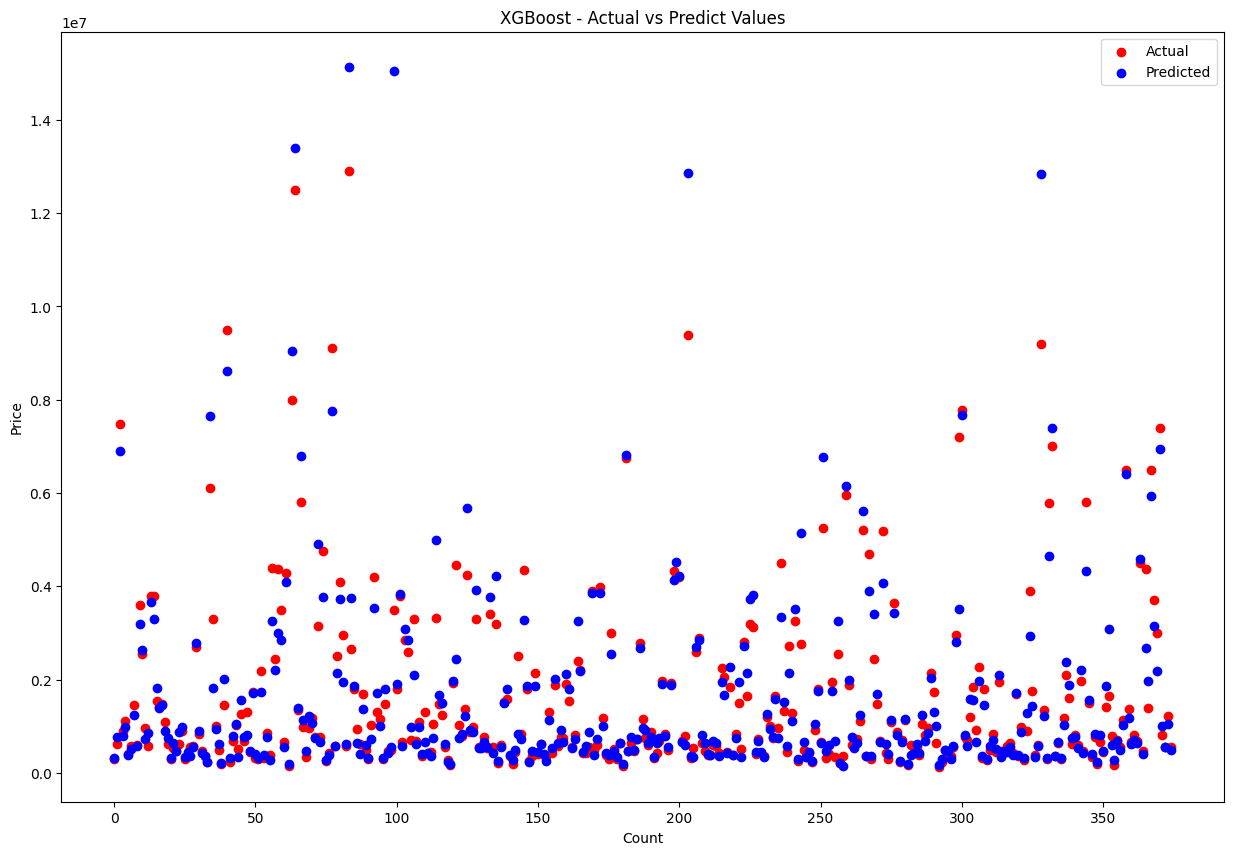

In [28]:
plt.figure(figsize=(15,10))
plt.scatter(range(len(y_test)), y_test, color="red")
plt.scatter(range(len(preds)), preds, color="blue")
plt.xlabel('Count')
plt.ylabel('Price')
plt.title("XGBoost - Actual vs Predict Values")
plt.legend(labels=['Actual', 'Predicted'])
plt.show()

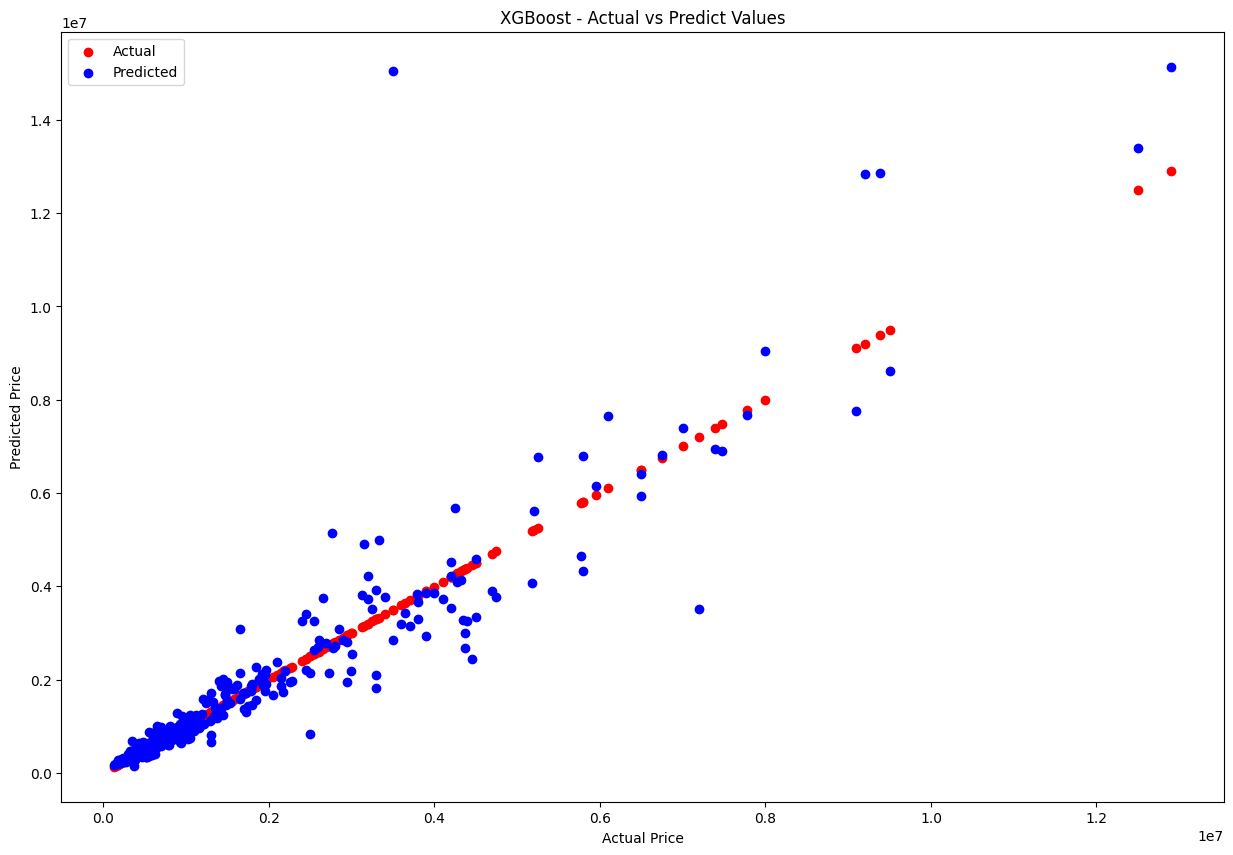

In [29]:
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_test, color="red")
plt.scatter(y_test, preds, color="blue")
plt.legend(labels=['Actual', 'Predicted'])
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title("XGBoost - Actual vs Predict Values")
plt.show()

## Neural Networks with Tensorflow

In [69]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [76]:
y_train = y_train.astype('float32')
y_train

264       145000.0
1561      990000.0
1043     3775000.0
795       695000.0
1742    12500000.0
           ...    
1245      425000.0
1423      434000.0
949      5250000.0
1602      675000.0
1241     3199000.0
Name: Price, Length: 1497, dtype: float32

In [77]:
X_train

array([[-2.52946866, -0.22093616, -0.98595772, ..., -0.40282388,
         0.65038742, -0.4326119 ],
       [-0.56918501,  0.75180559,  1.28477875, ..., -0.40282388,
        -1.5375451 ,  2.31154069],
       [ 1.0643847 , -0.04751656,  1.6983602 , ..., -0.40282388,
        -1.5375451 ,  2.31154069],
       ...,
       [ 1.0643847 , -0.412557  ,  0.42275458, ..., -0.40282388,
        -1.5375451 ,  2.31154069],
       [-0.24247107, -0.06170453, -0.4915615 , ..., -0.40282388,
         0.65038742, -0.4326119 ],
       [ 0.73767076, -0.76524125,  0.45127744, ..., -0.40282388,
         0.65038742, -0.4326119 ]])

In [90]:
tf.random.set_seed(42)

model = Sequential([
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(
    loss='mean_absolute_error',
    optimizer=Adam(),
    metrics=[rmse]
)

model.fit(X_train, y_train, epochs=30)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1710614.7500 - rmse: 2827405.7500
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1692899.3750 - rmse: 2814421.2500
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1371827.2500 - rmse: 2540577.5000
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 830425.5000 - rmse: 1742588.7500 
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 665652.3750 - rmse: 1468621.5000
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 567554.5000 - rmse: 1349459.2500
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 505997.2188 - rmse: 1261293.0000
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 468547.2812 - rmse: 1198048.1250
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 441015.5938 - rmse: 1137331.5000
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 417914.2188 - rmse: 1079699.2500
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 400063.5938 - rmse: 103372

In [91]:
preds2 = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [92]:
rmse2 = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds2)

print(f"RMSE: {rmse2:.2f}")
print(f"R-squared: {r2:.2f}")

RMSE: 814877.04
R-squared: 0.85


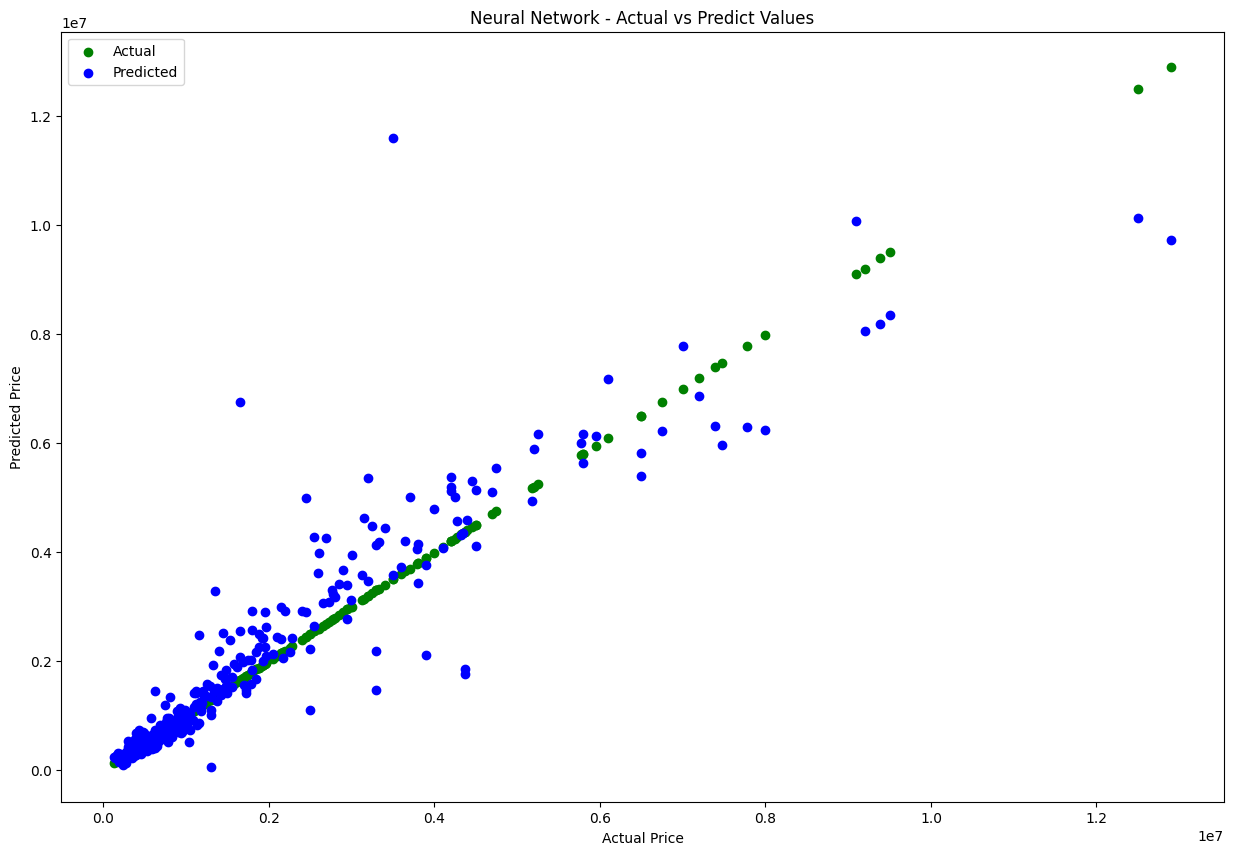

In [94]:
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_test, color="green")
plt.scatter(y_test, preds2, color="blue")
plt.legend(labels=['Actual', 'Predicted'])
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title("Neural Network - Actual vs Predict Values")
plt.show()